# Machine Reading IMF Data: Data Retrieval with Python
## Brian Dew, brianwdew@gmail.com

## Introduction
The International Monetary Fund (IMF) Statistics Department (STA) allows API access to their economic time series. Well-known datasets such as International Financial Statistics (IFS) and the World Economic Outlook (WEO) can be machine read through the API. This example will use python to read collect from STA's JSON RESTful Web Service so that we can determine the United States' share of world exports over the past 50 years. 


The [IMF knowledge base](http://datahelp.imf.org/knowledgebase/articles/630877-data-services) provides more information on the three avaiable API formats and IMF data services. For more information on the work of STA, see their PDF [annual report (PDF)](https://www.imf.org/external/np/sta/pdf/aglance.pdf}{https://www.imf.org/external/np/sta/pdf/aglance.pdf), STA at a glance 2015.

## Gathering series and dimension information
First, we will need to import the json, urllib2, and requests libraries, as well as pandas. These will allow us to read json data, open urls, and request information from the web. 

In [43]:
# Import libraries
import json
import urllib2
import requests
import pandas as pd
import numpy as np

Since we are using the JSON RESTful API, we start by using the 'Dataflow' endpoint URL to look at what series are available and find the series id of interest. The full output is long, so I've removed the data unrelated to this example. The IMF has many more series than what is shown below. 

In [44]:
# Find the series id and text name.
url = "http://dataservices.imf.org/REST/SDMX_JSON.svc/Dataflow/"
seriesids = json.load(urllib2.urlopen(url))
df = pd.DataFrame(seriesids['Structure']['KeyFamilies']['KeyFamily'])
for x in range(6, 13):    
    items = (str(df['@id'][x]), str(df['Name'][x]['#text']))
    print ': '.join(items)

DOT: Direction of Trade Statistics (DOTS)
FSIREM: Financial Soundness Indicators (FSI), Reporting Entities - Multidimensional
CDIS: Coordinated Direct Investment Survey (CDIS)
GFS01M: Government Finance Statistics (GFS 2001) - Multidimensional
GFS01: Government Finance Statistics (GFS 2001)
BOP: Balance of Payments (BOP)
BOPAGG: Balance of Payments (BOP), World and Regional Aggregates


We found above that the id for Direction of Trade Statistics is DOT. We can use this id to read notes about the series. We will next need to identify the *dimensions* of the data. For example, direction of trade data is based on a home country a flow and measure and a counterpart country. The data also has multiple frequencies and units of measurement. All of this information will be needed to later make our data request. 

In [45]:
# Annotations for the series
url = "http://dataservices.imf.org/REST/SDMX_JSON.svc/DataStructure/DOT"
dotstruct = json.load(urllib2.urlopen(url))
df = pd.DataFrame(dotstruct['Structure']['KeyFamilies']\
                  ['KeyFamily']['Annotations'])
for x in range(0, 7):    
    items = (str(df['Annotation'][x]['AnnotationTitle']), \
             str(df['Annotation'][x]['AnnotationText']['#text']))
    print ': '.join(items)

Latest Update Date: 05/25/2016
Name: Direction of Trade Statistics (DOTS)
Temporal Coverage: Monthly and quarterly data are available starting 1960. Annual data are available starting 1947.
Geographic Coverage: DOTS covers 184 countries, the world, and major areas.
Methodology: Guide to Direction of Trade Statistics, 1993. See Documents tab.
Definition: The <B>Direction of Trade Statistics (DOTS)</B> presents current figures on the value of merchandise exports and imports disaggregated according to a country's primary trading partners. Area and world aggregates are included in the display of trade flows between major areas of the world. Reported data is supplemented by estimates whenever such data is not available or current. Imports are reported on a cost, insurance and freight (CIF) basis and exports are reported on a free on board (FOB) basis, with the exception of a few countries for which imports are also available FOB. Time series data includes estimates derived from reports of p

In [46]:
# Look at structure of DOTS data to find the dimensions for our data request
url = "http://dataservices.imf.org/REST/SDMX_JSON.svc/DataStructure/DOT"
dotstruct = json.load(urllib2.urlopen(url))
df = pd.DataFrame(dotstruct['Structure']['KeyFamilies']['KeyFamily']\
                  ['Components']['Dimension'])
for x in range(0, 5):    
    items = ("Dimension", str(x+1), str(df['@codelist'][x]))
    print ': '.join(items)

Dimension: 1: CL_AREA_DOT
Dimension: 2: CL_INDICATOR_DOT
Dimension: 3: CL_COUNTERPART_AREA_DOT
Dimension: 4: CL_FREQ
Dimension: 5: CL_UNIT_MULT


We can now copy the code for each dimension into the CodeList Method to get the list of possible values. For example, we will need to identify the value of the first dimension, CL_COUNTRY, for the United States. Below, we show that the code is 111. I've manually placed the index number for the U.S. and World codes (again to save space), however, you can replace [200, 247] with [0, 247] to get the full list of country/area codes.

In [47]:
# Obtain country codes
url = "http://dataservices.imf.org/REST/SDMX_JSON.svc/CodeList/CL_AREA_DOT"
country = json.load(urllib2.urlopen(url))
df = pd.DataFrame(country['Structure']['CodeLists']['CodeList']['Code'])
for x in [200, 248]:    
    items = (str(df['@value'][x]), str(df['Description'][x]['#text']))
    print ': '.join(items)

US: United States
W00: All Countries, excluding the IO


The series ID is DOT and the country codes (we will use this with the exporting country, CL_COUNTRY, and the counterpart, CL_COUNTERPART_COUNTRY) of interest are 001 for world and 111 for the US. We see below that the indicator of interest is TXG_FOB_USD, Goods, Value of Exports, Free on board (FOB), US Dollars.

In [48]:
# Obtain series info and ids
url = "http://dataservices.imf.org/REST/SDMX_JSON.svc/CodeList/CL_INDICATOR_DOT"
series = json.load(urllib2.urlopen(url))
df = pd.DataFrame(series['Structure']['CodeLists']['CodeList']['Code'])
for x in range(0, 4):    
    items = (str(df['@value'][x]), str(df['Description'][x]['#text']))
    print ': '.join(items)

TXG_FOB_USD: Goods, Value of Exports, Free on board (FOB), US Dollars
TMG_CIF_USD: Goods, Value of Imports, Cost, Insurance, Freight (CIF), US Dollars
TMG_FOB_USD: Goods, Value of Imports, Free on board (FOB), US Dollars
All Indicators: All Indicators


We repeat the above steps for each dimension and record which series values are of interest to us. 

## Retrieving Data
The guide to STA's API shows how we can combine information from the previous steps to call and retrieve data. For direction of trade statistics, we see that the dimensions are as follows:

* Dimension 1: REF_AREA (the primary country) - 111
* Dimension 2: INDICATOR (the measure--we want to look at exports free of board) - TXG_FOB_USD
* Dimension 3: VIS_AREA (the counterpart country) - 001
* Dimension 4: FREQ (the frequency of the data--we want to use monthly data) - M 
* Dimension 5: SCALE (the units of measure--we can leave this blank)

The JSON RESTful API method for requesting the data is the CompactData Method. The format for putting together dimension and time period information is shown on the Web Service knowledge base as:

    http://dataservices.imf.org/REST/SDMX_JSON.svc/CompactData/{database ID}/ {item1 from dimension1}+{item2 from dimension1}{item N from dimension1}.{item1 from dimension2} +{item2 from dimension2}+{item M from dimension2}? startPeriod={start date}&endPeriod={end date}

Putting all of this information together, the URL to retrieve a JSON dictionary for 1966-2016 US exports to the world data is:

http://dataservices.imf.org/REST/SDMX_JSON.svc/CompactData/DOT/111.TXG_FOB_USD.001.M.?startPeriod=1966&endPeriod=2016

The python code which gets the data and saves it as a dictionary is as follows:

In [49]:
url = 'http://dataservices.imf.org/REST/SDMX_JSON.svc/CompactData/DOT/US.TXG_FOB_USD.W00.M.?startPeriod=1981&endPeriod=2016'
data = json.loads(requests.get(url).text)
usexp = pd.DataFrame(data['CompactData']['DataSet']['Series']['Obs'])
usexp.columns = ['status','usexports','date'];
usexp.tail()

,status,usexports,date
416,NaN,125394024247,2015-09
417,NaN,130599515853,2015-10
418,NaN,120731632371,2015-11
419,NaN,119907169367,2015-12
420,I_6,96533546087.7922,2016-01


Now we can do the same for the world exports. We combine the request for several series into one URL, by adding '+code_2+code3'. For example, '001+998.TXG..'

In [50]:
ourl = 'http://dataservices.imf.org/REST/SDMX_JSON.svc/CompactData/DOT/US+CN+JP+W00.TXG_FOB_USD.W00.M.?startPeriod=1972&endPeriod=2016'
odata = json.loads(requests.get(ourl).text);

In [51]:
wexp = pd.DataFrame(odata['CompactData']['DataSet']['Series'][0]['Obs'])
wexp.columns = ['observ','wexports','date']
del wexp['date']
del wexp['observ']
chexp = pd.DataFrame(odata['CompactData']['DataSet']['Series'][1]['Obs'])
chexp.columns = ['observ','chexports','date']
del chexp['date']
del chexp['observ']
jpexp = pd.DataFrame(odata['CompactData']['DataSet']['Series'][2]['Obs'])
jpexp.columns = ['jpexports','date']
del jpexp['date']
usexp = pd.DataFrame(odata['CompactData']['DataSet']['Series'][3]['Obs'])
usexp.columns = ['status','usexports','date'];

Now we combine the two series into one dataframe and tell our script to read the export value columns as numbers.

In [52]:
combined = pd.concat([usexp, wexp, chexp, jpexp], axis=1)
pd.to_datetime(combined.date)
combined = combined.set_index(pd.DatetimeIndex(combined['date']))
usexports = pd.to_numeric(combined.usexports)
wexports = pd.to_numeric(combined.wexports)
cexports = pd.to_numeric(combined.chexports)
jexports = pd.to_numeric(combined.jpexports)

Finally, we can calculate the U.S. percentage share of world exports. We simply divide the us exports by the world exports and multiply by 100. If using the data for economic research, we would likely take the log forms.


$$ \frac{\text{EX}_{US}}{\text{EX}_{world}} * 100 $$

In [53]:
combined['usshare'] = usexports / wexports * 100
combined['chinashare'] = cexports / wexports * 100
combined['japanshare'] = jexports / wexports * 100
combined.tail()

,status,usexports,date,wexports,chexports,jpexports,usshare,chinashare,japanshare
2015-09-01,NaN,125394024247,2015-09,1402408377305.19,205276102549,53319008022.613,8.941335,14.637398,3.801960
2015-10-01,NaN,130599515853,2015-10,1413766669636.51,192284415511,54483932950.8587,9.237699,13.600859,3.853814
2015-11-01,NaN,120731632371,2015-11,1343896101015.01,196294864154,48795599792.1326,8.983703,14.606402,3.630906
2015-12-01,NaN,119907169367,2015-12,1364400427444.03,223564683168,51982674657.9836,8.788268,16.385562,3.809928
2016-01-01,I_6,96533546087.7922,2016-01,1180747658048.74,177089181583,45233812900.6204,8.175629,14.998055,3.830947


## Graphing the data
Let's use matplotlib to view the result of our work.

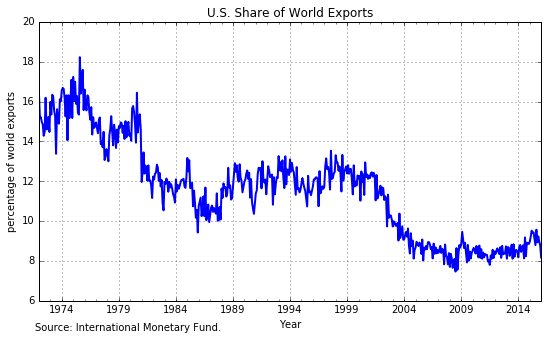

In [54]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
txt = '''Source: International Monetary Fund.'''

# Plot US share of world exports
combined.usshare.plot(grid=True, figsize=(9, 5), color="blue", linewidth=2,)
plt.ylabel('percentage of world exports')
plt.xlabel('Year')
plt.text(20,4.5,txt)
plt.title('U.S. Share of World Exports');

The graph shows a decrease in the U.S. share of exports from nearly 20 percent in 1966 to roughly 9 percent in 2015. We can also easily examine how changes in the U.S. share of exports compare with changes in the share of Japan and China.

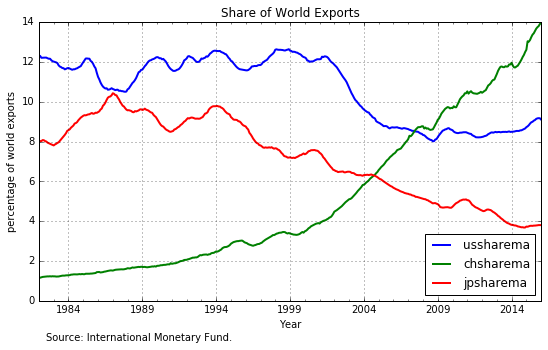

In [55]:
combined['ussharema'] = combined['usshare'].rolling(12,12).mean()
combined['chsharema'] = combined['chinashare'].rolling(12,12).mean()
combined['jpsharema'] = combined['japanshare'].rolling(12,12).mean()

combshares = combined[['ussharema', 'chsharema', 'jpsharema']]
shares = list(combshares);
# Plot various shares of world exports
combined[shares][120:].plot(grid=True, figsize=(9, 5), linewidth=2)
plt.ylabel('percentage of world exports')
plt.xlabel('Year')
plt.text(150,-2,txt)
plt.title('Share of World Exports', );

##  Export dataset to .csv
Let's save the dataset in a portable format that can be read by any statistical software. My preference is to create a .csv file, which I will use for my U.S. Macroeconomic and Markets Dashboard. 
https://briandew.wordpress.com/dashboard_usa/

In [56]:
combined.to_csv('us_share_exports.csv')